# Analysis section (split to new Notebook later)

In [30]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:39511 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 12 Memory: 16.68 GB


In [1]:
# Some basic statistical analysis
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet('no_curves.parquet')
df.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation,device_id
__null_dask_index__,,,,,,,,,,,,
0,0.0,656,11.523682,9.846436,61.972534,0.05,6.666667,5.555556,12.5,30,0,A
2667,1.0,657,15.266595,14.443375,62.441360,0.05,7.777778,5.555556,12.5,30,0,A
5334,2.0,658,15.240159,19.141264,81.540246,0.05,8.888889,5.555556,12.5,30,0,A
8001,3.0,659,15.327364,24.267203,73.593166,0.05,10.000000,5.555556,12.5,30,0,A
10668,4.0,660,9.056626,55.720365,100.097620,0.05,0.000000,6.666667,12.5,30,0,A


In [29]:
import seaborn as sns


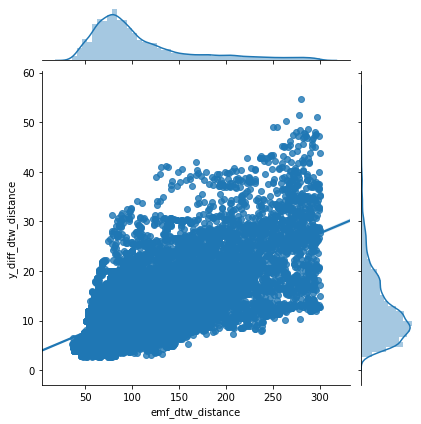

In [42]:
g = sns.jointplot('emf_dtw_distance',
                  'y_diff_dtw_distance',
                  df.query('emf_dtw_distance < 300'),
                  kind='reg')

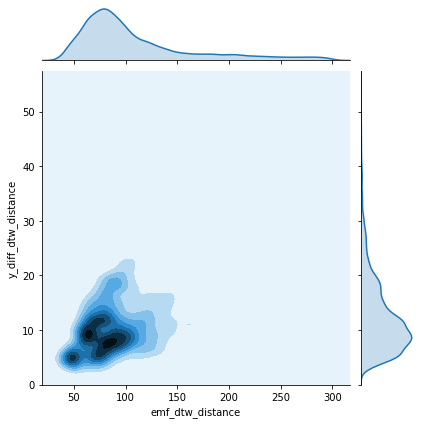

In [38]:
g = sns.jointplot('emf_dtw_distance',
                  'y_diff_dtw_distance',
                  df.query('emf_dtw_distance < 300'),
                  kind='kde')

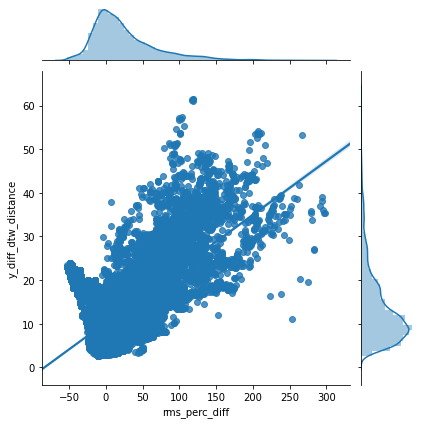

In [46]:
g = sns.jointplot('rms_perc_diff',
                  'y_diff_dtw_distance',
                  df.query('rms_perc_diff < 300'),
                  kind='reg')

(-10.0, 500.0)

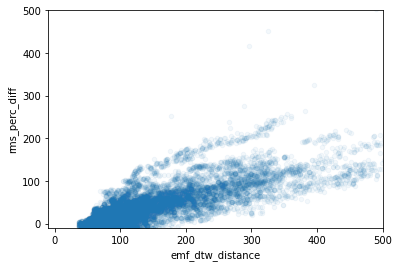

In [27]:
import matplotlib.pyplot as plt
df.plot(kind='scatter', x='emf_dtw_distance', y='rms_perc_diff', alpha=0.05)
plt.xlim(-10, 500)
plt.ylim(-10, 500)

In [3]:
no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(f + '.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(f + '.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

In [4]:
client.close()

---

In [1]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:45619 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.66 GB


In [2]:
root_path = './'
files = ['A', 'B', 'C']

In [3]:
dfs = []
for f in files:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')
    df['device_id'] = f
    df['input_excitation'] = df['input_excitation'].astype('int')
    dfs.append(df)
len(dfs)

3

In [4]:
dd.concat(dfs).to_parquet(root_path + 'joined.parquet', engine='pyarrow', partition_on=['device_id', 'input_excitation'], compression='brotli')

## Start here

In [264]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [265]:
df2 = pd.read_parquet('no_curves.parquet').reset_index(drop=True)
df2.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation,device_id
0,0.0,656,11.523682,9.846436,61.972534,0.05,6.666667,5.555556,12.5,30,0,A
1,1.0,657,15.266595,14.443375,62.441360,0.05,7.777778,5.555556,12.5,30,0,A
2,2.0,658,15.240159,19.141264,81.540246,0.05,8.888889,5.555556,12.5,30,0,A
3,3.0,659,15.327364,24.267203,73.593166,0.05,10.000000,5.555556,12.5,30,0,A
4,4.0,660,9.056626,55.720365,100.097620,0.05,0.000000,6.666667,12.5,30,0,A


In [266]:
df2_filtered = df2

In [267]:
# Some feature engineering
df2_filtered.loc[:, 'rms_perc_abs'] = np.abs(df2_filtered['rms_perc_diff'])
df2_filtered['dtw_mech'] = df2_filtered['y_diff_dtw_distance']
df2_filtered['dtw_mech_norm'] = (df2_filtered['dtw_mech'] - df2_filtered['dtw_mech'].min())/(df2_filtered['dtw_mech'].max() - df2_filtered['dtw_mech'].min())
df2_filtered['dtw_elec'] = df2_filtered['emf_dtw_distance']
df2_filtered['dtw_elec_norm'] = (df2_filtered['dtw_elec'] - df2_filtered['dtw_elec'].min())/(df2_filtered['dtw_elec'].max() - df2_filtered['dtw_elec'].min())
df2_filtered['dtw_both'] = df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['rms_perc_abs_norm'] = (df2_filtered['rms_perc_abs'] - df2_filtered['rms_perc_abs'].min())/(df2_filtered['rms_perc_abs'].max() - df2_filtered['rms_perc_abs'].min())
df2_filtered['rms_dtw_elec'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['balanced'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']

In [268]:
df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
0,0.0,656,11.523682,9.846436,61.972534,0.05,6.666667,5.555556,12.5,30,...,A,9.846436,11.523682,0.128360,61.972534,0.003696,0.132057,0.003031,0.006727,0.135088
1,1.0,657,15.266595,14.443375,62.441360,0.05,7.777778,5.555556,12.5,30,...,A,14.443375,15.266595,0.182149,62.441360,0.003765,0.185913,0.004447,0.008211,0.190360
2,2.0,658,15.240159,19.141264,81.540246,0.05,8.888889,5.555556,12.5,30,...,A,19.141264,15.240159,0.181769,81.540246,0.006548,0.188317,0.005893,0.012441,0.194210
3,3.0,659,15.327364,24.267203,73.593166,0.05,10.000000,5.555556,12.5,30,...,A,24.267203,15.327364,0.183022,73.593166,0.005390,0.188412,0.007471,0.012861,0.195883
4,4.0,660,9.056626,55.720365,100.097620,0.05,0.000000,6.666667,12.5,30,...,A,55.720365,9.056626,0.092907,100.097620,0.009252,0.102159,0.017156,0.026408,0.119315


In [269]:
# Remove model ids that perform really poorly

criteria = 'rms_perc_diff'
percent_samples = 0.9745
cut_off = (1-percent_samples)/2
upper_bound = df2_filtered[criteria].quantile(percent_samples)
lower_bound = df2_filtered[criteria].quantile(1-(percent_samples + cut_off))
print(lower_bound, upper_bound)

to_drop_lower = df2_filtered.query(f'{criteria} < {lower_bound}')['model_id'].values
to_drop_upper = df2_filtered.query(f'{criteria} > {upper_bound}')['model_id'].values

to_drop = np.concatenate([to_drop_lower, to_drop_upper])

df2_filtered = df2_filtered[~df2_filtered['model_id'].isin(to_drop)]

-40.485365852525 143.89886829076224


In [270]:
len(df2_filtered)

10472

In [271]:
df2_filtered.sort_values(by='rms_perc_diff', ascending=False)

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
154,2.0,234,18.199466,142.994413,156.651322,0.023333,4.444444,3.333333,12.5,30,...,A,142.994413,18.199466,0.224296,156.651322,0.017493,0.241790,0.044028,0.061521,0.285818
14,6.0,294,17.987781,142.839185,153.822366,0.023333,4.444444,10.000000,12.5,30,...,A,142.839185,17.987781,0.221254,153.822366,0.017081,0.238336,0.043980,0.061061,0.282315
496,0.0,264,18.172388,142.838307,162.324602,0.023333,4.444444,6.666667,12.5,30,...,A,142.838307,18.172388,0.223907,162.324602,0.018320,0.242227,0.043980,0.062300,0.286207
808,0.0,112,21.545624,142.608503,193.361593,0.016667,2.222222,1.111111,12.5,30,...,A,142.608503,21.545624,0.272383,193.361593,0.022843,0.295226,0.043909,0.066752,0.339135
988,4.0,284,18.713900,142.548275,155.870655,0.023333,4.444444,8.888889,12.5,30,...,A,142.548275,18.713900,0.231689,155.870655,0.017380,0.249069,0.043890,0.061270,0.292959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287,7.0,847,21.457120,-40.485366,94.328517,0.063333,7.777778,4.444444,12.5,30,...,A,40.485366,21.457120,0.271111,94.328517,0.008411,0.279523,0.012465,0.020876,0.291988
4301,5.0,877,21.457120,-40.485366,94.328517,0.063333,7.777778,7.777778,12.5,30,...,A,40.485366,21.457120,0.271111,94.328517,0.008411,0.279523,0.012465,0.020876,0.291988
4043,3.0,827,21.457120,-40.485366,94.328517,0.063333,7.777778,2.222222,12.5,30,...,A,40.485366,21.457120,0.271111,94.328517,0.008411,0.279523,0.012465,0.020876,0.291988
4445,5.0,837,21.457120,-40.485366,94.328517,0.063333,7.777778,3.333333,12.5,30,...,A,40.485366,21.457120,0.271111,94.328517,0.008411,0.279523,0.012465,0.020876,0.291988


In [272]:
print(len(df2))
len(df2_filtered)

22000


10472

In [273]:
df2_filtered.query('device_id == "A"').groupby(['input_excitation']).agg({'balanced': 'mean', 'y_diff_dtw_distance': 'mean'}).style.background_gradient(cmap='Reds')

,balanced,y_diff_dtw_distance
input_excitation,,
0,0.196574,14.481741
1,0.160756,12.540506
2,0.176858,13.831316
3,0.165296,12.737752
4,0.205677,15.693973
5,0.143920,11.592873
6,0.141109,11.339415


In [274]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({'y_diff_dtw_distance': 'mean'})
        .sort_values(by='y_diff_dtw_distance', ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

In [275]:
indexes_to_drop = []
for device, num in zip(['A', 'B', 'C'], [2, 2, 3]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    print(to_drop)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)

[4 0]
[2 6]
[2 6 3]


In [276]:
indexes_to_drop

[Int64Index([   0,    1,    2,    3,   10,   11,   12,   13,   14,   25,
             ...
             4967, 4984, 4985, 4990, 4991, 4995, 4996, 4997, 4998, 4999],
            dtype='int64', length=952),
 Int64Index([ 9000,  9001,  9002,  9003,  9004,  9005,  9006,  9007,  9009,
              9010,
             ...
             13988, 13990, 13991, 13993, 13994, 13995, 13996, 13997, 13998,
             13999],
            dtype='int64', length=952),
 Int64Index([16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008,
             16009,
             ...
             20987, 20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995,
             20999],
            dtype='int64', length=1428)]

In [277]:
len(df2_filtered)

10472

In [278]:
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)

In [279]:
len(df2_filtered)

7140

In [280]:
df_scores = df2_filtered.groupby(['model_id']).agg({
    'dtw_mech': 'mean',
    'dtw_elec': 'mean',
    'dtw_both': 'mean',
    'rms_perc_abs': 'mean',
    'rms_dtw_elec': 'mean',
    'balanced': 'mean'
})
df_scores.head()

,dtw_mech,dtw_elec,dtw_both,rms_perc_abs,rms_dtw_elec,balanced
model_id,,,,,,
110,18.754400,154.155037,0.249401,37.065552,0.028542,0.260813
112,15.896264,158.875026,0.209015,41.596585,0.030625,0.221822
130,17.877877,157.394108,0.237277,39.875331,0.029879,0.249554
150,19.684758,159.204843,0.263507,39.198274,0.029934,0.275575
180,18.775188,154.422102,0.249739,37.934911,0.028848,0.261418


In [281]:
# Let's get the best performing model ids for each objective_function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'dtw_mech': 484,
 'dtw_elec': 776,
 'dtw_both': 574,
 'rms_perc_abs': 655,
 'rms_dtw_elec': 604,
 'balanced': 574}

In [282]:
best_param_sets = [v for v in best_model_ids.values()]

In [317]:
df2_filtered.query('model_id == 604')

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
1428,4.0,604,9.064834,9.430547,72.148216,0.05,4.444444,0.0,12.5,30,...,A,9.430547,9.064834,0.093025,72.148216,0.005179,0.098204,0.002903,0.008082,0.101107
2092,4.0,604,11.937147,-5.865667,76.231999,0.05,4.444444,0.0,12.5,30,...,A,5.865667,11.937147,0.134302,76.231999,0.005774,0.140076,0.001805,0.007580,0.141882
3772,4.0,604,18.530878,21.441119,62.486067,0.05,4.444444,0.0,12.5,30,...,A,21.441119,18.530878,0.229059,62.486067,0.003771,0.232830,0.006601,0.010372,0.239431
5500,4.0,604,21.403271,0.933188,68.063003,0.05,4.444444,0.0,12.5,30,...,A,0.933188,21.403271,0.270338,68.063003,0.004584,0.274921,0.000287,0.004871,0.275208
6228,4.0,604,10.764986,7.507362,68.941645,0.05,4.444444,0.0,12.5,30,...,A,7.507362,10.764986,0.117457,68.941645,0.004712,0.122169,0.002311,0.007023,0.124480
7220,4.0,604,7.890812,15.346049,94.805371,0.05,4.444444,0.0,23.5,30,...,B,15.346049,7.890812,0.076153,94.805371,0.008481,0.084634,0.004724,0.013205,0.089358
8620,4.0,604,5.253570,-5.518686,65.107863,0.05,4.444444,0.0,23.5,30,...,B,5.518686,5.253570,0.038254,65.107863,0.004153,0.042407,0.001699,0.005852,0.044106
10428,4.0,604,7.409768,28.273969,76.289213,0.05,4.444444,0.0,23.5,30,...,B,28.273969,7.409768,0.069240,76.289213,0.005783,0.075023,0.008705,0.014488,0.083728
11076,4.0,604,6.540245,5.012956,87.270341,0.05,4.444444,0.0,23.5,30,...,B,5.012956,6.540245,0.056744,87.270341,0.007383,0.064127,0.001543,0.008926,0.065670
12252,4.0,604,5.510078,-3.358313,78.724359,0.05,4.444444,0.0,23.5,30,...,B,3.358313,5.510078,0.041940,78.724359,0.006137,0.048078,0.001033,0.007171,0.049111


In [284]:
letters = [r'$A$', r'$B$', r'$C$', r'$D$', r'$E$', 'F', 'G']
letter_index = 0
seen_model_ids = []
model_id_to_letter_mapping = {}

for k, v in best_model_ids.items():
    if v not in model_id_to_letter_mapping.keys():
        model_id_to_letter_mapping[v] = letters[letter_index]
        letter_index += 1

In [285]:
model_id_to_letter_mapping 

{484: '$A$', 776: '$B$', 574: '$C$', 655: '$D$', 604: '$E$'}

In [286]:
# Just for illustration
for k, v in best_model_ids.items():
    print(k, model_id_to_letter_mapping[v])

dtw_mech $A$
dtw_elec $B$
dtw_both $C$
rms_perc_abs $D$
rms_dtw_elec $E$
balanced $C$


In [287]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets)]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_letter_mapping[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,grid.cell.id,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.damping.coefficient,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.resistance,load.model.R,...,rms.perc.abs,dtw.mech,dtw.mech.norm,dtw.elec,dtw.elec.norm,dtw.both,rms.perc.abs.norm,rms.dtw.elec,balanced,metric.name
1340,4.0,484,14.511832,30.013752,96.841068,0.036667,4.444444,8.888889,12.5,30,...,30.013752,14.511832,0.171302,96.841068,0.008778,0.180080,0.009241,0.018018,0.189320,$A$
1428,4.0,604,9.064834,9.430547,72.148216,0.050000,4.444444,0.000000,12.5,30,...,9.430547,9.064834,0.093025,72.148216,0.005179,0.098204,0.002903,0.008082,0.101107,$E$
1536,0.0,776,12.088716,6.311365,74.840056,0.056667,6.666667,7.777778,12.5,30,...,6.311365,12.088716,0.136480,74.840056,0.005571,0.142052,0.001943,0.007514,0.143994,$B$
1662,6.0,574,8.895317,16.756613,90.365341,0.043333,4.444444,7.777778,12.5,30,...,16.756613,8.895317,0.090589,90.365341,0.007834,0.098422,0.005159,0.012993,0.103581,$C$
1759,7.0,655,8.932354,10.374532,79.525863,0.050000,5.555556,5.555556,12.5,30,...,10.374532,8.932354,0.091121,79.525863,0.006254,0.097375,0.003194,0.009448,0.100569,$D$


In [288]:
df_filtered_scores_melt = df_filtered_scores.melt(id_vars=['model.id', 'metric.name'], value_vars=['rms.perc.diff', 'dtw.mech', 'dtw.elec'])
df_filtered_scores_melt.head()

,model.id,metric.name,variable,value
0,484,$A$,rms.perc.diff,30.013752
1,604,$E$,rms.perc.diff,9.430547
2,776,$B$,rms.perc.diff,6.311365
3,574,$C$,rms.perc.diff,16.756613
4,655,$D$,rms.perc.diff,10.374532


In [309]:
def phd_theme():
    return theme(
        axis_line=element_line(color='black', size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_title_x=element_text(size=16, margin={'t': 12}),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=16),
        axis_text=element_text(size=12),
        panel_background=element_blank(),
        panel_border=element_blank(),
        panel_grid=element_blank(),
        legend_key=element_blank(),
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_position=(0.8, 0.8),
        legend_direction='vertical',
    )

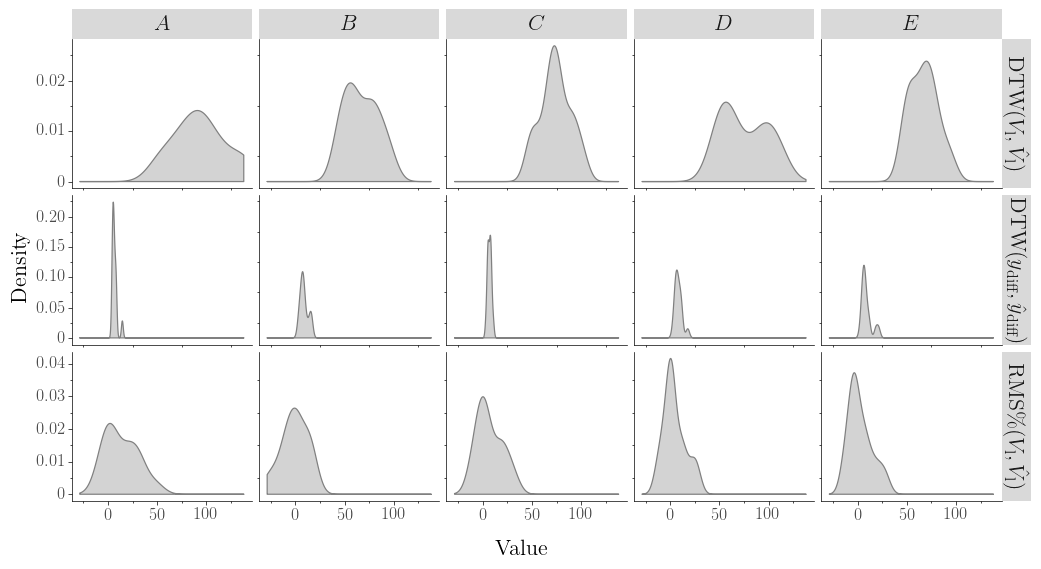

<ggplot: (8735587119431)>

In [310]:
from plotnine import *
from matplotlib import rc
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{amsmath}')
rc('text', usetex=True)

cols_rename = {'dtw.elec': r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$',
               'dtw.mech': r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}})$',
               'rms.perc.diff': r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$'}

lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='value'), df_filtered_scores_melt)
p = (
    p
    + geom_density(fill='lightgrey', color='grey') 
    + facet_grid('variable ~ metric.name', scales='free_y', labeller=lblr) 
    + xlab('Value')
    + ylab('Density')
    + theme(figure_size=(12, 6)) 
    + phd_theme()
)
#p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 8 in image.
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf


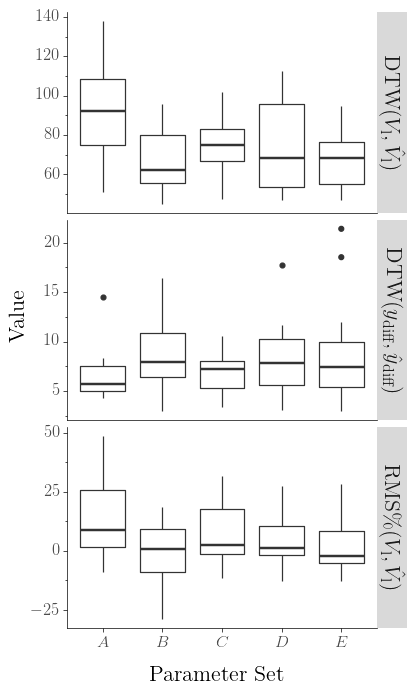

<ggplot: (8735674351224)>

In [311]:
lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='metric.name', y='value'), df_filtered_scores_melt)
p = (
    p
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free_y', labeller=lblr)
    + phd_theme()
    + theme(figure_size=(4, 8))
    + xlab('Parameter Set')
    + ylab('Value')
)
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

In [312]:
df2_filtered.query('model_id == 575')

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
1663,7.0,575,9.314958,21.742703,100.448445,0.043333,5.555556,7.777778,12.5,30,...,A,21.742703,9.314958,0.096619,100.448445,0.009303,0.105922,0.006694,0.015997,0.112616
2279,7.0,575,10.252655,3.312038,66.150626,0.043333,5.555556,7.777778,12.5,30,...,A,3.312038,10.252655,0.110095,66.150626,0.004305,0.114400,0.001019,0.005324,0.115419
3111,7.0,575,8.019270,33.771718,59.461683,0.043333,5.555556,7.777778,12.5,30,...,A,33.771718,8.019270,0.077999,59.461683,0.003330,0.081330,0.010398,0.013728,0.091727
5447,7.0,575,6.998015,10.936742,54.645453,0.043333,5.555556,7.777778,12.5,30,...,A,10.936742,6.998015,0.063323,54.645453,0.002629,0.065951,0.003367,0.005995,0.069318
6999,7.0,575,7.761620,19.859515,63.202371,0.043333,5.555556,7.777778,12.5,30,...,A,19.859515,7.761620,0.074297,63.202371,0.003875,0.078172,0.006114,0.009990,0.084286
7303,7.0,575,7.896353,22.210743,113.098195,0.043333,5.555556,7.777778,23.5,30,...,B,22.210743,7.896353,0.076233,113.098195,0.011147,0.087379,0.006838,0.017985,0.094217
8087,7.0,575,5.511103,-0.541800,64.952961,0.043333,5.555556,7.777778,23.5,30,...,B,0.541800,5.511103,0.041955,64.952961,0.004131,0.046085,0.000166,0.004297,0.046252
10647,7.0,575,6.942787,29.142790,115.023163,0.043333,5.555556,7.777778,23.5,30,...,B,29.142790,6.942787,0.062529,115.023163,0.011427,0.073956,0.008973,0.020400,0.082929
11791,7.0,575,8.412582,11.800960,115.213926,0.043333,5.555556,7.777778,23.5,30,...,B,11.800960,8.412582,0.083651,115.213926,0.011455,0.095106,0.003633,0.015088,0.098739
12415,7.0,575,4.532542,6.587962,79.606068,0.043333,5.555556,7.777778,23.5,30,...,B,6.587962,4.532542,0.027892,79.606068,0.006266,0.034158,0.002028,0.008294,0.036186


In [47]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

Client Scheduler: tcp://127.0.0.1:41005 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.68 GB


In [48]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


class GroundTruthFactory:
    def __init__(self, samples_list, lvp_kwargs, adc_kwargs):
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs
        
        @dataclass
        class MechanicalGroundtruth:
            y_diff: Any
            time: Any
        
        @dataclass
        class ElectricalGroundtruth:
            emf: Any
            time: Any
        
        @dataclass
        class Groundtruth:
            mech: MechanicalGroundtruth
            elec: ElectricalGroundtruth

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)
        self.MechGroundtruth = MechanicalGroundtruth
        self.ElecGroundtruth = ElectricalGroundtruth
        self.Groundtruth = Groundtruth

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return self.MechGroundtruth(y_target,
                                    y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return self.ElecGroundtruth(emf_target,
                                    emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            mech_groundtruth = self._make_mechanical_groundtruth(sample)
            elec_groundtruth = self._make_electrical_groundtruth(sample)

            groundtruths.append(
                self.Groundtruth(mech_groundtruth, elec_groundtruth)
            )

        return groundtruths

# Prepare data
base_groundtruth_path = './data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [49]:
# Groundtruth

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples_list=samples[device][:],
                                             lvp_kwargs=dict(mm=10,
                                                             seconds_per_frame=1/60,
                                                             pixel_scale=0.154508),
                                             adc_kwargs=dict(voltage_division_ratio=1 / 0.342)  # noqa
    )
    groundtruth[device] = groundtruth_factory.make()

In [50]:
# Let's look at some examples from each

In [51]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number, device_id):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'device_id', 'time', 'emf', 'y_diff'],
                                filters=[('device_id', '==', device_id), ('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp[df_temp['device_id'] == device_id].compute()
    return df_temp.sort_values(by='time')

In [52]:
def compare_mech(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device_id][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device_id][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [53]:
def compare_elec(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device_id][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device_id][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff}
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x
    return elec_eval

In [54]:
from scipy import signal

{'dtw_distance': 5.587799103566159}


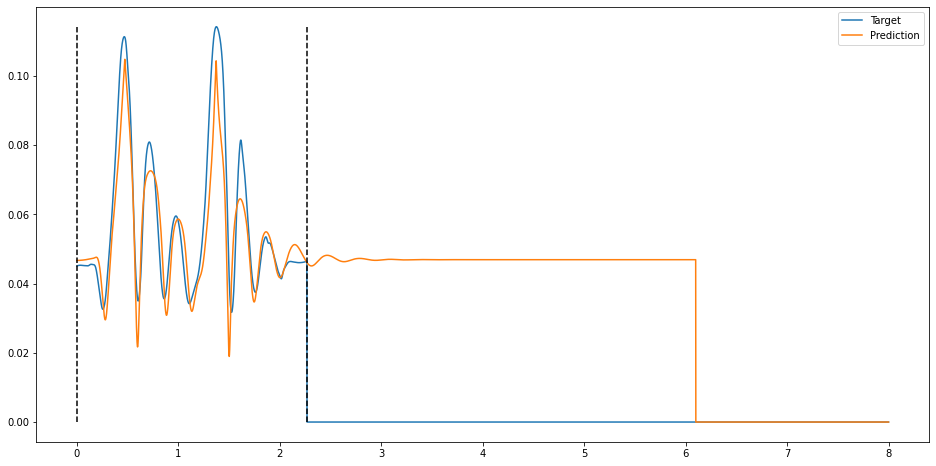

{'dtw_distance': 68.99841822435589, 'rms_perc_diff': -0.6250555464577698}


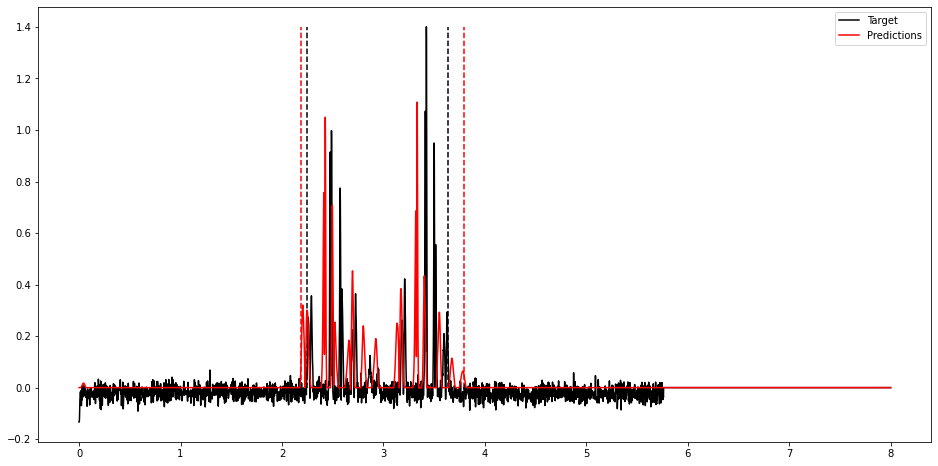

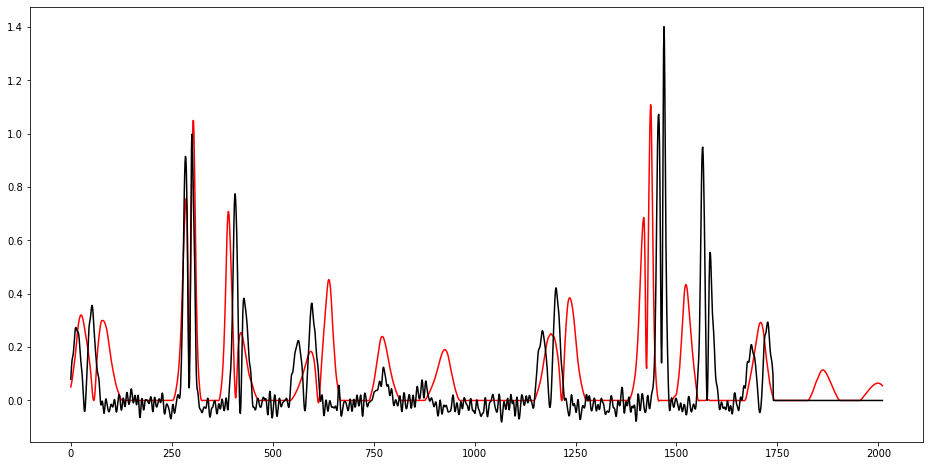

In [58]:
input_ = 1
device = 'B'
chosen_model_id = 575

compare_mech('joined.parquet', groundtruth, chosen_model_id, input_, device)
ee = compare_elec('joined.parquet', groundtruth, chosen_model_id, input_, device)

plt.figure(figsize=(16, 8))
plt.plot(ee.emf_predict_clipped_, 'r')
plt.plot(ee.emf_target_clipped_, 'k')

In [56]:
emf_target_clipped_ = ee.emf_target_clipped_
emf_predict_clipped_ = ee.emf_predict_clipped_
clip_indexes = ee._clip_indexes

## Correlation investigation

In [49]:
df_sample = get_curve('joined.parquet', 661, 0, 'A')

In [50]:
g = groundtruth['A'][0]

In [51]:
pred_time = df_sample['time'].values
pred_emf = df_sample['emf'].values

truth_time = g.elec.time
truth_emf = g.elec.emf

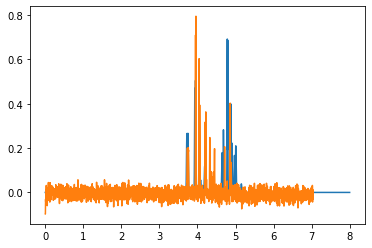

In [52]:
import matplotlib.pyplot as plt
plt.plot(pred_time, pred_emf)
plt.plot(truth_time, truth_emf)

In [56]:
# Start experiment
from scipy import signal
import numpy as np

# sampling periods
sampling_period_pred_time = np.mean(np.gradient(pred_time))
sampling_period_truth_time = np.mean(np.gradient(truth_time))

# Figure out up/down sampling ratio
ratio = sampling_period_pred_time/sampling_period_truth_time
ratio = np.round(ratio, 3)
up = ratio*1e3
down = 1e3

# We need to do a resampling period first
pred_emf_scaled = signal.resample_poly(pred_emf, up, down)

In [57]:
print(ratio)

4.799


In [58]:
pred_time_scaled = np.arange(0., max(pred_time), sampling_period_pred_time/ratio)
pred_time_scaled

array([0.00000000e+00, 6.24953721e-04, 1.24990744e-03, ...,
       7.99753277e+00, 7.99815772e+00, 7.99878268e+00])

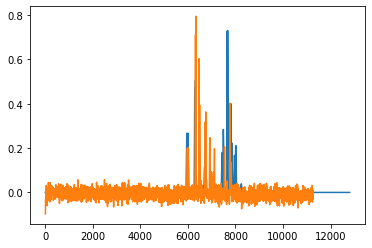

In [59]:
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

12800
12804


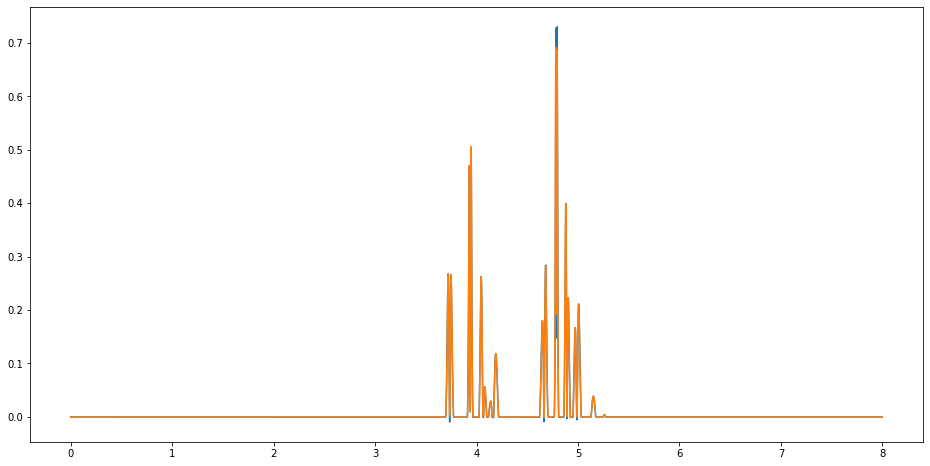

In [61]:
print(len(pred_time_scaled))
print(len(pred_emf_scaled))

# Just make sure any odd samples get clipped
pred_emf_scaled = pred_emf_scaled[:len(pred_time_scaled)]
pred_time_scaled = pred_time_scaled[:len(pred_emf_scaled)]

# Plot
plt.figure(figsize=(16, 8))
plt.plot(pred_time_scaled, pred_emf_scaled)
plt.plot(pred_time, pred_emf)

In [62]:
# Now that we've resampled, we can do correlation
corr_12 = signal.correlate(pred_emf_scaled, truth_emf)
corr_21 = signal.correlate(truth_emf, pred_emf_scaled)

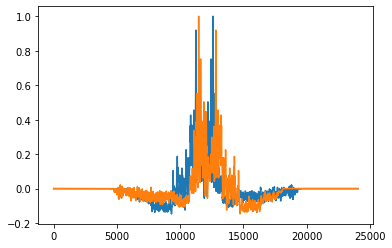

In [63]:
plt.plot(corr_12/max(corr_12))
plt.plot(corr_21/max(corr_21))

In [64]:
first_pos = np.argmax(corr_12)
second_pos = np.argmax(corr_21)

print(first_pos)
print(second_pos)

12599
11463


In [65]:
difference = first_pos - second_pos
difference

1136

In [68]:
if difference < 0:
    padded_pred = np.pad(pred_emf_scaled, (abs(difference), 0), 'constant')
if difference > 0:
    padded_pred = np.pad(pred_emf_scaled, (0, abs(difference)), 'constant')

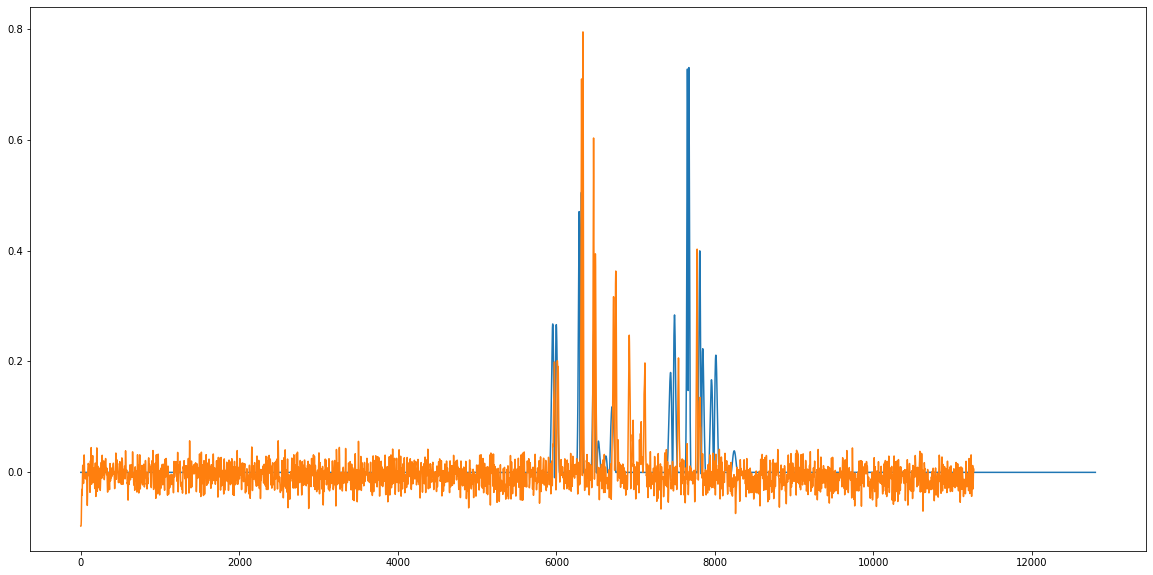

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

In [70]:
from unified_model.utils.utils import find_signal_limits

In [71]:
# Another technique

start_truth, end_truth = find_signal_limits(truth_emf, 0.075)
start_pred, end_pred = find_signal_limits(pred_emf_scaled, 0.05)

In [72]:
start_pred - start_truth

-36

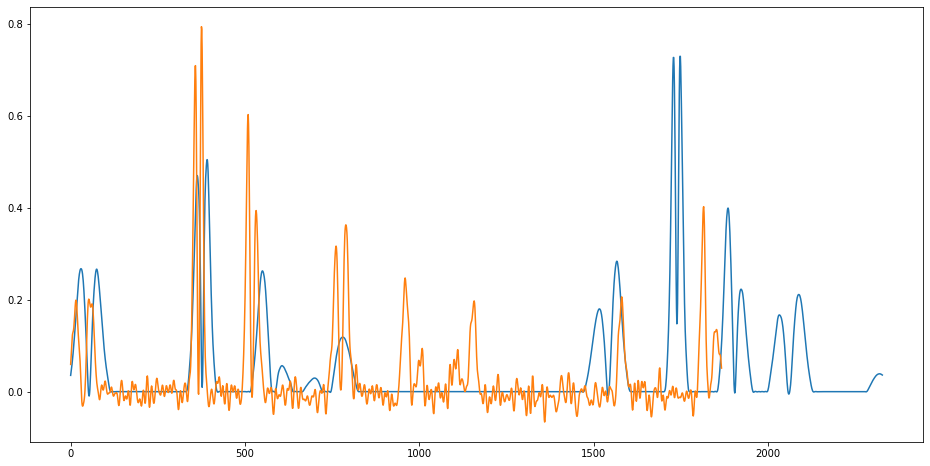

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(pred_emf_scaled[start_pred:end_pred])
plt.plot(truth_emf[start_truth:end_truth])